In [7]:
# Install required packages
!pip install nltk scikit-learn PyPDF2 python-docx fastapi uvicorn pydantic numpy
!pip install python-multipart  # For handling file uploads in FastAPI

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import PyPDF2
import docx
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        """Clean and normalize text"""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words and len(word) > 2]

        return ' '.join(tokens)

In [10]:
class JobDescriptionSummarizer:
    def __init__(self):
        self.preprocessor = TextPreprocessor()

    def extract_key_elements(self, job_description):
        """Extract key requirements and responsibilities from job description"""
        # Preprocess the text
        processed_text = self.preprocessor.preprocess_text(job_description)

        # Look for typical sections
        requirements = []
        responsibilities = []
        skills = []

        # Simple rule-based extraction (can be enhanced with NLP models)
        sections = re.split(r'\n\s*\n', job_description.lower())
        for section in sections:
            if any(keyword in section for keyword in ['requirement', 'qualification', 'what you need']):
                # Extract bullet points or lines
                points = re.findall(r'(?:•|\*|\-|\d+\.)\s*(.*?)(?=(?:•|\*|\-|\d+\.)|$)', section)
                if not points:  # If no bullet points, split by newlines
                    points = [line.strip() for line in section.split('\n') if line.strip()]
                requirements.extend(points)

            if any(keyword in section for keyword in ['responsibilit', 'duty', 'what you\'ll do']):
                points = re.findall(r'(?:•|\*|\-|\d+\.)\s*(.*?)(?=(?:•|\*|\-|\d+\.)|$)', section)
                if not points:
                    points = [line.strip() for line in section.split('\n') if line.strip()]
                responsibilities.extend(points)

            if 'skill' in section:
                skill_matches = re.findall(r'(?:•|\*|\-|\d+\.)\s*(.*?)(?=(?:•|\*|\-|\d+\.)|$)', section)
                if not skill_matches:
                    skill_matches = [line.strip() for line in section.split('\n') if line.strip()]
                skills.extend(skill_matches)

        # Extract job title
        title_match = re.search(r'job title:?\s*(.*?)(?:\n|$)', job_description, re.IGNORECASE)
        job_title = title_match.group(1).strip() if title_match else ""

        # Use keyword extraction for important terms
        # We'll use a simple frequency-based approach here
        words = processed_text.split()
        word_freq = {}
        for word in words:
            if len(word) > 2:  # Skip very short words
                word_freq[word] = word_freq.get(word, 0) + 1

        # Get top keywords
        keywords = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
        keywords = [k[0] for k in keywords]

        return {
            "job_title": job_title,
            "responsibilities": responsibilities,
            "requirements": requirements,
            "skills": skills,
            "keywords": keywords,
            "processed_text": processed_text
        }

In [11]:
class ResumeDataExtractor:
    def __init__(self):
        self.preprocessor = TextPreprocessor()

    def read_pdf(self, file_path):
        """Extract text from PDF file"""
        text = ""
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                text += page.extract_text() + "\n"
        return text

    def read_docx(self, file_path):
        """Extract text from DOCX file"""
        doc = docx.Document(file_path)
        text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
        return text

    def read_resume(self, file_path):
        """Read resume file based on extension"""
        if file_path.endswith('.pdf'):
            return self.read_pdf(file_path)
        elif file_path.endswith('.docx'):
            return self.read_docx(file_path)
        else:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()

    def extract_sections(self, text):
        """Extract different sections from resume"""
        sections = {}

        # Common section headers in resumes
        section_headers = [
            "education", "experience", "work experience", "employment",
            "skills", "technical skills", "projects", "certifications",
            "awards", "publications", "languages", "interests",
            "summary", "objective", "contact"
        ]

        # Find potential section headers
        lines = text.split('\n')
        current_section = "header"
        sections[current_section] = []

        for i, line in enumerate(lines):
            line_lower = line.lower().strip()

            # Check if this line could be a section header
            is_header = False
            for header in section_headers:
                if header in line_lower and (line_lower.startswith(header) or
                                            len(line_lower) < 50):  # Heuristic: headers are typically short
                    current_section = header
                    sections[current_section] = []
                    is_header = True
                    break

            if not is_header:
                sections[current_section].append(line)

        # Join the section contents back
        for section in sections:
            sections[section] = '\n'.join(sections[section])

        return sections

    def extract_key_data(self, resume_text):
        """Extract key information from resume"""
        # Preprocess the text
        processed_text = self.preprocessor.preprocess_text(resume_text)

        # Extract sections
        sections = self.extract_sections(resume_text)

        # Extract education
        education = sections.get("education", "")
        education_info = []
        # Look for degree patterns
        degree_patterns = [
            r'(?:bachelor|master|phd|b\.s\.|m\.s\.|ph\.d)\s+(?:of|in)\s+([^,\.]*)',
            r'([^\n,\.]*?)\s+(?:degree|diploma)',
        ]
        for pattern in degree_patterns:
            matches = re.findall(pattern, education.lower())
            education_info.extend(matches)

        # Extract experience
        experience = sections.get("experience", "") or sections.get("work experience", "") or sections.get("employment", "")

        # Extract job titles from experience
        job_titles = []
        job_title_patterns = [
            r'(?:^|\n)([A-Z][^\n]*?)\n',  # Capitalized lines
            r'(?:as|position|title):\s*([^,\.]*)',  # "as: Title" or "Position: Title"
        ]
        for pattern in job_title_patterns:
            matches = re.findall(pattern, experience)
            job_titles.extend([match.strip() for match in matches if len(match.strip()) > 3])

        # Extract skills
        skills_text = sections.get("skills", "") or sections.get("technical skills", "")
        # Look for skill patterns - comma or bullet separated items
        skills = []
        if skills_text:
            # Try to find skills listed with bullets
            bullet_skills = re.findall(r'(?:•|\*|\-|\d+\.)\s*([^•\*\-\d\n]*)', skills_text)
            skills.extend([s.strip() for s in bullet_skills if s.strip()])

            # Try to find comma-separated skills
            comma_skills = re.findall(r'([^,\n]*?)(?:,|$)', skills_text)
            skills.extend([s.strip() for s in comma_skills if s.strip() and len(s.strip()) < 50])

        # If skills section doesn't exist or is empty, try to extract skills from the whole text
        if not skills:
            # Look for technical/programming languages and tools
            tech_patterns = [
                r'(?:proficient in|familiar with|knowledge of|experience with|skilled in)\s+([^\.]*)',
                r'(?:languages|frameworks|tools|technologies):\s+([^\.]*)',
            ]
            for pattern in tech_patterns:
                matches = re.findall(pattern, resume_text.lower())
                for match in matches:
                    skill_list = re.split(r',|\band\b|\|', match)
                    skills.extend([s.strip() for s in skill_list if s.strip()])

        # Extract years of experience
        years_exp = []
        year_patterns = [
            r'(\d+)\+?\s*(?:years|yrs)',
            r'(\d{4})\s*(?:-|to)\s*(?:present|current|\d{4})',
        ]
        for pattern in year_patterns:
            matches = re.findall(pattern, resume_text.lower())
            years_exp.extend(matches)

        # Use keyword extraction for important terms
        words = processed_text.split()
        word_freq = {}
        for word in words:
            if len(word) > 2:  # Skip very short words
                word_freq[word] = word_freq.get(word, 0) + 1

        # Get top keywords
        keywords = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:30]
        keywords = [k[0] for k in keywords]

        return {
            "education": education_info,
            "job_titles": job_titles,
            "skills": skills,
            "years_experience": years_exp,
            "keywords": keywords,
            "processed_text": processed_text
        }

In [12]:
class JobResumeMatcher:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=2,
            max_df=0.8,
            sublinear_tf=True,
            use_idf=True
        )
        self.trained = False

    def fit_vectorizer(self, corpus):
        """Train the TF-IDF vectorizer on a corpus of text"""
        self.vectorizer.fit(corpus)
        self.trained = True
        return self

    def calculate_similarity(self, text1, text2):
        """Calculate cosine similarity between two texts"""
        try:
            # Use transform if already trained, otherwise fit_transform
            if self.trained:
                vec1 = self.vectorizer.transform([text1])
                vec2 = self.vectorizer.transform([text2])
            else:
                # If not trained, fit on both texts (less accurate but works)
                tfidf_matrix = self.vectorizer.fit_transform([text1, text2])
                vec1 = tfidf_matrix[0:1]
                vec2 = tfidf_matrix[1:2]

            return cosine_similarity(vec1, vec2)[0][0]
        except Exception as e:
            print(f"Error calculating similarity: {e}")
            return 0.0

    def calculate_keyword_match(self, keywords1, keywords2):
        """Calculate keyword match percentage"""
        if not keywords1 or not keywords2:
            return 0.0

        matches = set(keywords1).intersection(set(keywords2))
        return len(matches) / max(len(keywords1), len(keywords2))

    def calculate_skills_match(self, job_skills, resume_skills):
        """Calculate match between required skills and resume skills"""
        if not job_skills or not resume_skills:
            return 0.0

        # Convert lists to sets of lowercase skills
        job_skills_set = set(' '.join(job_skills).lower().split())
        resume_skills_set = set(' '.join(resume_skills).lower().split())

        # Calculate intersection
        matches = job_skills_set.intersection(resume_skills_set)

        # Return match percentage based on job requirements
        return len(matches) / len(job_skills_set) if job_skills_set else 0.0

    def match_resume_to_job(self, job_data, resume_data):
        """Match resume data to job data and generate a score"""
        scores = {}

        # 1. Overall text similarity (30% of total score)
        text_similarity = self.calculate_similarity(
            job_data['processed_text'],
            resume_data['processed_text']
        )
        scores['text_similarity'] = text_similarity * 30

        # 2. Skills match (40% of total score)
        skills_match = self.calculate_skills_match(
            job_data['skills'] + job_data['requirements'],
            resume_data['skills']
        )
        scores['skills_match'] = skills_match * 40

        # 3. Keyword match (20% of total score)
        keyword_match = self.calculate_keyword_match(
            job_data['keywords'],
            resume_data['keywords']
        )
        scores['keyword_match'] = keyword_match * 20

        # 4. Job title match (10% of total score)
        title_match = 0.0
        if job_data['job_title'] and resume_data['job_titles']:
            # Check if any resume job title matches the job description title
            job_title_words = set(job_data['job_title'].lower().split())
            for title in resume_data['job_titles']:
                title_words = set(title.lower().split())
                overlap = len(job_title_words.intersection(title_words)) / len(job_title_words) if job_title_words else 0
                title_match = max(title_match, overlap)
        scores['title_match'] = title_match * 10

        # Calculate total score
        total_score = sum(scores.values())

        # Round to nearest integer
        total_score = round(total_score)

        # Ensure the score is between 0 and 100
        total_score = max(0, min(100, total_score))

        return {
            'total_score': total_score,
            'detailed_scores': scores,
            'match_details': {
                'matching_skills': list(set([s.lower() for s in resume_data['skills']]).intersection(
                    [s.lower() for s in (job_data['skills'] + job_data['requirements'])])),
                'missing_skills': list(set([s.lower() for s in (job_data['skills'] + job_data['requirements'])]).difference(
                    [s.lower() for s in resume_data['skills']])),
            }
        }

    def save_model(self, file_path='jd_resume_matcher_model.pkl'):
        """Save the trained model to a file"""
        if not self.trained:
            print("Warning: Saving untrained model")

        with open(file_path, 'wb') as f:
            pickle.dump(self.vectorizer, f)

        print(f"Model saved to {file_path}")

    def load_model(self, file_path='jd_resume_matcher_model.pkl'):
        """Load a trained model from a file"""
        with open(file_path, 'rb') as f:
            self.vectorizer = pickle.load(f)

        self.trained = True
        print(f"Model loaded from {file_path}")
        return self

In [13]:
class ResumeJobMatchingSystem:
    def __init__(self, load_model_path=None):
        self.jd_summarizer = JobDescriptionSummarizer()
        self.resume_extractor = ResumeDataExtractor()
        self.matcher = JobResumeMatcher()

        # Load pre-trained model if path is provided
        if load_model_path and os.path.exists(load_model_path):
            try:
                self.matcher.load_model(load_model_path)
                print(f"Loaded model from {load_model_path}")
            except Exception as e:
                print(f"Error loading model: {e}")

    def process_job_description(self, jd_text):
        """Process and summarize job description"""
        return self.jd_summarizer.extract_key_elements(jd_text)

    def process_resume(self, resume_path):
        """Process and extract key data from resume"""
        resume_text = self.resume_extractor.read_resume(resume_path)
        return self.resume_extractor.extract_key_data(resume_text)

    def match_resume_to_job(self, job_data, resume_data):
        """Match resume to job and calculate score"""
        return self.matcher.match_resume_to_job(job_data, resume_data)

    def process_text_resume(self, resume_text):
        """Process resume from text"""
        return self.resume_extractor.extract_key_data(resume_text)

    def train_model(self, job_descriptions, resumes):
        """Train the model on a corpus of job descriptions and resumes"""
        # Combine all text for training the vectorizer
        corpus = []

        # Add processed job descriptions
        for jd in job_descriptions:
            job_data = self.process_job_description(jd)
            corpus.append(job_data["processed_text"])

        # Add processed resumes
        for resume in resumes:
            if isinstance(resume, str):
                resume_data = self.process_text_resume(resume)
            else:
                resume_data = self.process_resume(resume)
            corpus.append(resume_data["processed_text"])

        # Train the vectorizer
        self.matcher.fit_vectorizer(corpus)
        print(f"Model trained on {len(corpus)} documents")

        return self

    def save_model(self, file_path='jd_resume_matcher_model.pkl'):
        """Save the trained model to a file"""
        self.matcher.save_model(file_path)

In [23]:
# Import libraries for dataset handling
import pandas as pd
import os
from google.colab import files

print("Let's prepare our job and resume datasets for training...")

# Step 1: Upload the dataset files
print("\n--- STEP 1: UPLOADING FILES ---")
print("Please upload your job descriptions CSV file (job_title_des.csv)")
print("and resume dataset CSV file (UpdatedResumeDataSet.csv)")
print("You can upload both files at once.")
uploaded = files.upload()

# Step 2: Process the uploaded files
print("\n--- STEP 2: PROCESSING UPLOADED FILES ---")
job_descriptions = []
resumes = []

# Check which files were uploaded and process them
for filename in uploaded.keys():
    print(f"Processing {filename}...")

    if 'job' in filename.lower():
        # This is the job descriptions file
        try:
            job_df = pd.read_csv(filename)
            print(f"Successfully loaded job dataset with {len(job_df)} entries and columns: {job_df.columns.tolist()}")

            # Get the job description column (might be named differently in different datasets)
            if 'JD' in job_df.columns:
                job_descriptions = job_df['JD'].tolist()
            elif 'job_description' in job_df.columns:
                job_descriptions = job_df['job_description'].tolist()
            elif 'description' in job_df.columns:
                job_descriptions = job_df['description'].tolist()
            else:
                # Try to find a text column with job descriptions
                text_cols = [col for col in job_df.columns if job_df[col].dtype == 'object']
                if text_cols:
                    # Use the column with the longest average text
                    lens = {col: job_df[col].astype(str).str.len().mean() for col in text_cols}
                    best_col = max(lens, key=lens.get)
                    job_descriptions = job_df[best_col].tolist()
                    print(f"Used column '{best_col}' for job descriptions")
                else:
                    print("Could not identify job description column. Please check the file format.")

        except Exception as e:
            print(f"Error processing job file: {e}")

    elif 'resume' in filename.lower():
        # This is the resume file
        try:
            resume_df = pd.read_csv(filename)
            print(f"Successfully loaded resume dataset with {len(resume_df)} entries and columns: {resume_df.columns.tolist()}")

            # Get the resume text column (might be named differently in different datasets)
            if 'Resume' in resume_df.columns:
                resumes = resume_df['Resume'].tolist()
            elif 'resume_text' in resume_df.columns:
                resumes = resume_df['resume_text'].tolist()
            elif 'text' in resume_df.columns:
                resumes = resume_df['text'].tolist()
            else:
                # Try to find a text column with resumes
                text_cols = [col for col in resume_df.columns if resume_df[col].dtype == 'object']
                if text_cols:
                    # Use the column with the longest average text
                    lens = {col: resume_df[col].astype(str).str.len().mean() for col in text_cols}
                    best_col = max(lens, key=lens.get)
                    resumes = resume_df[best_col].tolist()
                    print(f"Used column '{best_col}' for resumes")
                else:
                    print("Could not identify resume text column. Please check the file format.")

        except Exception as e:
            print(f"Error processing resume file: {e}")

# Step 3: Handle missing data with sample datasets if needed
print("\n--- STEP 3: CHECKING DATA COMPLETENESS ---")

# Create sample job descriptions if none were loaded
if not job_descriptions:
    print("No job descriptions were loaded. Creating sample job data...")
    job_descriptions = [
        """
        Job Title: Data Scientist
        Requirements: Python, R, Machine Learning, SQL
        Responsibilities: Analyze data, Build models, Present findings
        """,
        """
        Job Title: Software Engineer
        Requirements: Java, Python, Cloud Computing, CI/CD
        Responsibilities: Develop applications, Fix bugs, Write tests
        """,
        """
        Job Title: Product Manager
        Requirements: Product development, Agile, User research
        Responsibilities: Define roadmap, Work with engineering, Talk to customers
        """
    ]
    print(f"Created {len(job_descriptions)} sample job descriptions")

# Create sample resumes if none were loaded
if not resumes:
    print("No resumes were loaded. Creating sample resume data...")
    resumes = [
        """
        JOHN DOE
        Data Scientist with 5 years of experience

        EDUCATION
        Master of Science in Data Science

        EXPERIENCE
        Senior Data Scientist at Tech Co (2020-Present)
        • Built machine learning models using Python and TensorFlow
        • Analyzed large datasets using SQL and Pandas

        Data Analyst at Analytics Inc (2018-2020)
        • Conducted statistical analysis
        • Created dashboards using Tableau

        SKILLS
        Python, R, SQL, Machine Learning, Statistics, Tableau
        """,
        """
        JANE SMITH
        Software Engineer

        EDUCATION
        Bachelor of Science in Computer Science

        EXPERIENCE
        Software Engineer at Web Solutions (2019-Present)
        • Developed backend services using Java and Spring
        • Implemented CI/CD pipelines

        Junior Developer at Tech Startup (2017-2019)
        • Wrote code in Python and JavaScript
        • Fixed bugs and implemented new features

        SKILLS
        Java, Python, JavaScript, AWS, Docker, Git
        """,
        """
        ROBERT JOHNSON
        Product Manager

        EDUCATION
        MBA in Product Management

        EXPERIENCE
        Product Manager at Software Co (2018-Present)
        • Defined product roadmap and strategy
        • Worked with engineering and design teams

        Associate Product Manager at Tech Inc (2016-2018)
        • Gathered customer requirements
        • Managed product backlog

        SKILLS
        Product Strategy, Agile, User Research, Market Analysis
        """
    ]
    print(f"Created {len(resumes)} sample resumes")

# Step 4: Sample the datasets if they're too large
print("\n--- STEP 4: PREPARING FINAL DATASETS ---")
max_samples = 1000  # Adjust based on your computational resources

if len(job_descriptions) > max_samples:
    import random
    job_descriptions = random.sample(job_descriptions, max_samples)
    print(f"Sampled {max_samples} job descriptions for efficient training")

if len(resumes) > max_samples:
    import random
    resumes = random.sample(resumes, max_samples)
    print(f"Sampled {max_samples} resumes for efficient training")

# Final report
print("\n--- FINAL DATASET SUMMARY ---")
print(f"Loaded {len(job_descriptions)} job descriptions and {len(resumes)} resumes for training")

# Display a sample from each dataset
if job_descriptions:
    print("\nSample job description:")
    print(job_descriptions[0][:300] + "..." if len(job_descriptions[0]) > 300 else job_descriptions[0])

if resumes:
    print("\nSample resume:")
    print(resumes[0][:300] + "..." if len(resumes[0]) > 300 else resumes[0])

# Now these datasets can be used for your model training

Let's prepare our job and resume datasets for training...

--- STEP 1: UPLOADING FILES ---
Please upload your job descriptions CSV file (job_title_des.csv)
and resume dataset CSV file (UpdatedResumeDataSet.csv)
You can upload both files at once.


Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet (2).csv
Saving job_title_des.csv to job_title_des (2).csv

--- STEP 2: PROCESSING UPLOADED FILES ---
Processing UpdatedResumeDataSet (2).csv...
Successfully loaded resume dataset with 962 entries and columns: ['Category', 'Resume']
Processing job_title_des (2).csv...
Successfully loaded job dataset with 2277 entries and columns: ['Unnamed: 0', 'Job Title', 'Job Description']
Used column 'Job Description' for job descriptions

--- STEP 3: CHECKING DATA COMPLETENESS ---

--- STEP 4: PREPARING FINAL DATASETS ---
Sampled 1000 job descriptions for efficient training

--- FINAL DATASET SUMMARY ---
Loaded 1000 job descriptions and 962 resumes for training

Sample job description:
Back end Admin\ Back end Developers
Job Description
We are looking for experienced Back-end developers to join our company you will be responsible for the server side of our web applications, and also website handling
If you have excellent programming skills and

In [27]:
df = pd.read_csv("UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [26]:
df2 = pd.read_csv("job_title_des.csv")
df2.head()

,Unnamed: 0,Job Title,Job Description
0,0,Flutter Developer,We are looking for hire experts flutter develo...
1,1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,4,Full Stack Developer,job responsibility full stack engineer – react...


In [29]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Clean and preprocess text data"""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize and remove stopwords
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    else:
        return ""

# Apply preprocessing to both datasets
print("Preprocessing job descriptions...")
processed_job_descriptions = [preprocess_text(jd) for jd in job_descriptions]

print("Preprocessing resumes...")
processed_resumes = [preprocess_text(resume) for resume in resumes]

print("Preprocessing complete.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing job descriptions...
Preprocessing resumes...
Preprocessing complete.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
print("Creating TF-IDF vectorizer...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on both job descriptions and resumes
all_documents = processed_job_descriptions + processed_resumes
tfidf_vectorizer.fit(all_documents)

# Transform job descriptions and resumes to TF-IDF features
print("Transforming job descriptions to TF-IDF features...")
job_tfidf = tfidf_vectorizer.transform(processed_job_descriptions)

print("Transforming resumes to TF-IDF features...")
resume_tfidf = tfidf_vectorizer.transform(processed_resumes)

print(f"Job descriptions shape: {job_tfidf.shape}")
print(f"Resumes shape: {resume_tfidf.shape}")

Creating TF-IDF vectorizer...
Transforming job descriptions to TF-IDF features...
Transforming resumes to TF-IDF features...
Job descriptions shape: (1000, 5000)
Resumes shape: (962, 5000)


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def match_resume_to_jobs(resume_idx, resume_features, job_features, job_descriptions, top_n=5):
    """Match a resume to the most relevant job descriptions based on cosine similarity"""
    # Get the feature vector for the given resume
    resume_vector = resume_features[resume_idx]

    # Calculate cosine similarity between resume and all job descriptions
    similarities = cosine_similarity(resume_vector, job_features).flatten()

    # Get the indices of the top N most similar job descriptions
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Create a result dataframe with job descriptions and similarity scores
    results = []
    for idx in top_indices:
        results.append({
            'Match Score': f"{similarities[idx]:.2f}",
            'Job Description': job_descriptions[idx][:200] + "..." if len(job_descriptions[idx]) > 200 else job_descriptions[idx]
        })

    return pd.DataFrame(results)

# Test the matching function with a sample resume
sample_idx = 0
print(f"Sample resume:\n{resumes[sample_idx][:300]}...\n")
print("Top matching job descriptions:")
matches = match_resume_to_jobs(sample_idx, resume_tfidf, job_tfidf, job_descriptions)
display(matches)

Sample resume:
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language pr...

Top matching job descriptions:


,Match Score,Job Description
0,0.27,Req ID:93123\n\nWe create smart innovations to...
1,0.22,Job Description:\n\nKEY QUALIFICATIONS\n\nSoli...
2,0.22,We are building our team to offer business and...
3,0.21,Your Profile:\nWill demonstrate cross function...
4,0.21,We are looking for strong Data Scientists/Anal...


In [32]:
def match_job_to_resumes(job_idx, job_features, resume_features, resumes, top_n=5):
    """Match a job description to the most relevant resumes based on cosine similarity"""
    # Get the feature vector for the given job
    job_vector = job_features[job_idx]

    # Calculate cosine similarity between job and all resumes
    similarities = cosine_similarity(job_vector, resume_features).flatten()

    # Get the indices of the top N most similar resumes
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Create a result dataframe with resumes and similarity scores
    results = []
    for idx in top_indices:
        results.append({
            'Match Score': f"{similarities[idx]:.2f}",
            'Resume': resumes[idx][:200] + "..." if len(resumes[idx]) > 200 else resumes[idx]
        })

    return pd.DataFrame(results)

# Test the matching function with a sample job description
sample_job_idx = 0
print(f"Sample job description:\n{job_descriptions[sample_job_idx][:300]}...\n")
print("Top matching resumes:")
job_matches = match_job_to_resumes(sample_job_idx, job_tfidf, resume_tfidf, resumes)
display(job_matches)

Sample job description:
Back end Admin\ Back end Developers
Job Description
We are looking for experienced Back-end developers to join our company you will be responsible for the server side of our web applications, and also website handling
If you have excellent programming skills and a passion for developing applications...

Top matching resumes:


,Match Score,Resume
0,0.18,Education Details \r\n BE Computer Science Mum...
1,0.18,Education Details \r\n BE Computer Science Mum...
2,0.16,"Technologies ASP.NET, MVC 3.0/4.0/5.0, Unit Te..."
3,0.16,"Technologies ASP.NET, MVC 3.0/4.0/5.0, Unit Te..."
4,0.16,"Technologies ASP.NET, MVC 3.0/4.0/5.0, Unit Te..."


In [33]:
def resume_job_matcher_ui():
    """Interactive function to match resumes to jobs and vice versa"""
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Create dropdown menus
    match_type = widgets.Dropdown(
        options=['Match Resume to Jobs', 'Match Job to Resumes'],
        description='Select:',
        value='Match Resume to Jobs'
    )

    # Create a text input for search
    search_input = widgets.Text(
        value='',
        placeholder='Enter keywords to filter by',
        description='Search:',
        disabled=False
    )

    # Create a slider for the number of results
    num_results = widgets.IntSlider(
        value=5,
        min=1,
        max=20,
        step=1,
        description='Results:',
        disabled=False
    )

    # Create a button for execution
    button = widgets.Button(description="Find Matches")
    output = widgets.Output()

    # Define button click behavior
    def on_button_clicked(b):
        with output:
            clear_output()

            if match_type.value == 'Match Resume to Jobs':
                # Filter resumes based on search keywords
                filtered_indices = []
                if search_input.value:
                    keywords = search_input.value.lower().split()
                    for i, resume in enumerate(resumes):
                        if any(keyword in resume.lower() for keyword in keywords):
                            filtered_indices.append(i)
                else:
                    filtered_indices = list(range(len(resumes)))

                if not filtered_indices:
                    print("No resumes match your search criteria.")
                    return

                # Select a random resume from the filtered list
                import random
                idx = random.choice(filtered_indices)

                print(f"Selected Resume (ID: {idx}):")
                print("=" * 80)
                print(resumes[idx][:500] + "..." if len(resumes[idx]) > 500 else resumes[idx])
                print("=" * 80)
                print(f"\nTop {num_results.value} matching jobs:")
                matches = match_resume_to_jobs(idx, resume_tfidf, job_tfidf, job_descriptions, num_results.value)
                display(matches)

            else:  # Match Job to Resumes
                # Filter jobs based on search keywords
                filtered_indices = []
                if search_input.value:
                    keywords = search_input.value.lower().split()
                    for i, job in enumerate(job_descriptions):
                        if any(keyword in job.lower() for keyword in keywords):
                            filtered_indices.append(i)
                else:
                    filtered_indices = list(range(len(job_descriptions)))

                if not filtered_indices:
                    print("No jobs match your search criteria.")
                    return

                # Select a random job from the filtered list
                import random
                idx = random.choice(filtered_indices)

                print(f"Selected Job Description (ID: {idx}):")
                print("=" * 80)
                print(job_descriptions[idx][:500] + "..." if len(job_descriptions[idx]) > 500 else job_descriptions[idx])
                print("=" * 80)
                print(f"\nTop {num_results.value} matching resumes:")
                matches = match_job_to_resumes(idx, job_tfidf, resume_tfidf, resumes, num_results.value)
                display(matches)

    # Connect the button click to the function
    button.on_click(on_button_clicked)

    # Display the UI
    display(widgets.VBox([
        widgets.HBox([match_type, search_input]),
        widgets.HBox([num_results, button]),
        output
    ]))

# Launch the interactive UI
resume_job_matcher_ui()

In [34]:
def extract_skills(text):
    """Extract skills from text using a predefined skills list"""
    # Define a list of common skills (you can expand this)
    common_skills = [
        'python', 'java', 'javascript', 'sql', 'html', 'css', 'react', 'angular',
        'vue', 'node', 'express', 'django', 'flask', 'spring', 'hibernate',
        'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy', 'r',
        'tableau', 'power bi', 'excel', 'word', 'powerpoint', 'photoshop',
        'illustrator', 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins',
        'git', 'agile', 'scrum', 'kanban', 'jira', 'confluence',
        'machine learning', 'deep learning', 'nlp', 'computer vision',
        'data analysis', 'data visualization', 'statistics', 'calculus',
        'linear algebra', 'product management', 'project management',
        'communication', 'leadership', 'teamwork', 'problem solving',
        'critical thinking', 'creativity', 'time management', 'organization'
    ]

    # Find skills in the text
    text_lower = text.lower()
    found_skills = []

    for skill in common_skills:
        if re.search(r'\b' + re.escape(skill) + r'\b', text_lower):
            found_skills.append(skill)

    return found_skills

# Extract skills from job descriptions and resumes
print("Extracting skills from job descriptions...")
job_skills = [extract_skills(jd) for jd in job_descriptions]

print("Extracting skills from resumes...")
resume_skills = [extract_skills(resume) for resume in resumes]

# Enhanced matching function using skills overlap and TF-IDF
def enhanced_resume_job_matching(resume_idx, resume_features, job_features,
                                 resume_skills_list, job_skills_list, job_descriptions, top_n=5):
    """Match a resume to jobs using both TF-IDF similarity and skills overlap"""
    # Get the feature vector for the given resume
    resume_vector = resume_features[resume_idx]

    # Calculate TF-IDF similarity
    tfidf_similarities = cosine_similarity(resume_vector, job_features).flatten()

    # Calculate skills overlap ratio
    resume_skills = set(resume_skills_list[resume_idx])
    skills_overlap = []

    for job_skills in job_skills_list:
        job_skills_set = set(job_skills)
        if not job_skills_set or not resume_skills:
            skills_overlap.append(0)
        else:
            overlap = len(resume_skills.intersection(job_skills_set))
            max_skills = max(len(resume_skills), len(job_skills_set))
            skills_overlap.append(overlap / max_skills if max_skills > 0 else 0)

    # Combine the scores (weighted average)
    tfidf_weight = 0.7
    skills_weight = 0.3
    combined_scores = (tfidf_weight * tfidf_similarities) + (skills_weight * np.array(skills_overlap))

    # Get the indices of the top N jobs
    top_indices = combined_scores.argsort()[-top_n:][::-1]

    # Create a result dataframe
    results = []
    for idx in top_indices:
        job_skills_matched = set(job_skills_list[idx]).intersection(resume_skills)

        results.append({
            'Match Score': f"{combined_scores[idx]:.2f}",
            'TF-IDF Score': f"{tfidf_similarities[idx]:.2f}",
            'Skills Match': f"{skills_overlap[idx]:.2f}",
            'Matched Skills': ', '.join(job_skills_matched),
            'Job Description': job_descriptions[idx][:200] + "..." if len(job_descriptions[idx]) > 200 else job_descriptions[idx]
        })

    return pd.DataFrame(results)

# Test the enhanced matching
sample_idx = 0
print(f"Sample resume skills: {resume_skills[sample_idx]}")
print("\nEnhanced job matches:")
enhanced_matches = enhanced_resume_job_matching(sample_idx, resume_tfidf, job_tfidf,
                                               resume_skills, job_skills, job_descriptions)
display(enhanced_matches)

Extracting skills from job descriptions...
Extracting skills from resumes...
Sample resume skills: ['python', 'java', 'javascript', 'sql', 'html', 'css', 'angular', 'node', 'flask', 'scikit-learn', 'pandas', 'numpy', 'tableau', 'word', 'docker', 'git', 'machine learning', 'deep learning', 'computer vision']

Enhanced job matches:


,Match Score,TF-IDF Score,Skills Match,Matched Skills,Job Description
0,0.28,0.27,0.32,"deep learning, javascript, python, machine lea...",Req ID:93123\n\nWe create smart innovations to...
1,0.25,0.16,0.47,"deep learning, docker, python, machine learnin...",About Us:\nCareerNinja is building a personali...
2,0.24,0.19,0.37,"html, python, machine learning, git, numpy, sq...","Summary\n\nThe Gas, Power, and Energy Futures ..."
3,0.23,0.20,0.32,"deep learning, computer vision, python, machin...",Ellie Mae is the leading cloud-based platform ...
4,0.22,0.14,0.42,"deep learning, docker, computer vision, python...",Job Description :\n\nWe are looking for outsta...


In [35]:
import pickle

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Create a dictionary with all the necessary components
resume_job_matcher = {
    'vectorizer': tfidf_vectorizer,
    'job_tfidf': job_tfidf,
    'resume_tfidf': resume_tfidf,
    'job_skills': job_skills,
    'resume_skills': resume_skills
}

# Save the model
with open('resume_job_matcher.pkl', 'wb') as f:
    pickle.dump(resume_job_matcher, f)

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [36]:
def match_new_resume(resume_text, top_n=5):
    """Match a new resume with existing jobs"""
    # Preprocess the resume
    processed_resume = preprocess_text(resume_text)

    # Transform to TF-IDF features
    resume_vector = tfidf_vectorizer.transform([processed_resume])

    # Extract skills
    skills = extract_skills(resume_text)
    print(f"Extracted skills: {skills}")

    # Calculate TF-IDF similarity
    tfidf_similarities = cosine_similarity(resume_vector, job_tfidf).flatten()

    # Calculate skills overlap
    skills_overlap = []
    for job_skill_list in job_skills:
        job_skills_set = set(job_skill_list)
        if not job_skills_set or not skills:
            skills_overlap.append(0)
        else:
            overlap = len(set(skills).intersection(job_skills_set))
            max_skills = max(len(skills), len(job_skills_set))
            skills_overlap.append(overlap / max_skills if max_skills > 0 else 0)

    # Combine scores
    tfidf_weight = 0.7
    skills_weight = 0.3
    combined_scores = (tfidf_weight * tfidf_similarities) + (skills_weight * np.array(skills_overlap))

    # Get top matches
    top_indices = combined_scores.argsort()[-top_n:][::-1]

    # Create results
    results = []
    for idx in top_indices:
        job_skills_matched = set(job_skills[idx]).intersection(skills)

        results.append({
            'Match Score': f"{combined_scores[idx]:.2f}",
            'Matched Skills': ', '.join(job_skills_matched),
            'Job Description': job_descriptions[idx][:200] + "..." if len(job_descriptions[idx]) > 200 else job_descriptions[idx]
        })

    return pd.DataFrame(results)

# Test with a new resume
new_resume = """
JANE SMITH
Data Scientist with 6 years of experience

EDUCATION
Ph.D. in Computer Science, Stanford University

EXPERIENCE
Senior Data Scientist at TechCorp (2018-Present)
- Led a team of 5 data scientists on multiple projects
- Developed machine learning models for customer segmentation
- Improved recommendation algorithms resulting in 15% revenue increase

Data Scientist at AI Solutions (2015-2018)
- Built NLP models for sentiment analysis
- Created data visualization dashboards using Tableau

SKILLS
Python, R, SQL, TensorFlow, PyTorch, Scikit-learn, Pandas, NumPy,
Tableau, Power BI, Machine Learning, Deep Learning, NLP, Statistics
"""

print("Matching new resume to existing jobs:")
new_matches = match_new_resume(new_resume)
display(new_matches)

Matching new resume to existing jobs:
Extracted skills: ['python', 'sql', 'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy', 'r', 'tableau', 'power bi', 'machine learning', 'deep learning', 'nlp', 'data visualization', 'statistics']


,Match Score,Matched Skills,Job Description
0,0.48,"deep learning, nlp, pytorch, python, tensorflo...",We are looking for a Senior Data Scientist to ...
1,0.47,"deep learning, nlp, pytorch, python, tensorflo...",About Us:\nCareerNinja is building a personali...
2,0.45,"deep learning, nlp, python, tensorflow, machin...",Job Description:\nWe are looking for an experi...
3,0.42,"deep learning, pytorch, python, tensorflow, r,...",Data Scientist\n\nWe are looking for a Data Sc...
4,0.41,"deep learning, nlp, pytorch, python, tensorflo...",Job Description:\n\nKEY QUALIFICATIONS\n\nSoli...


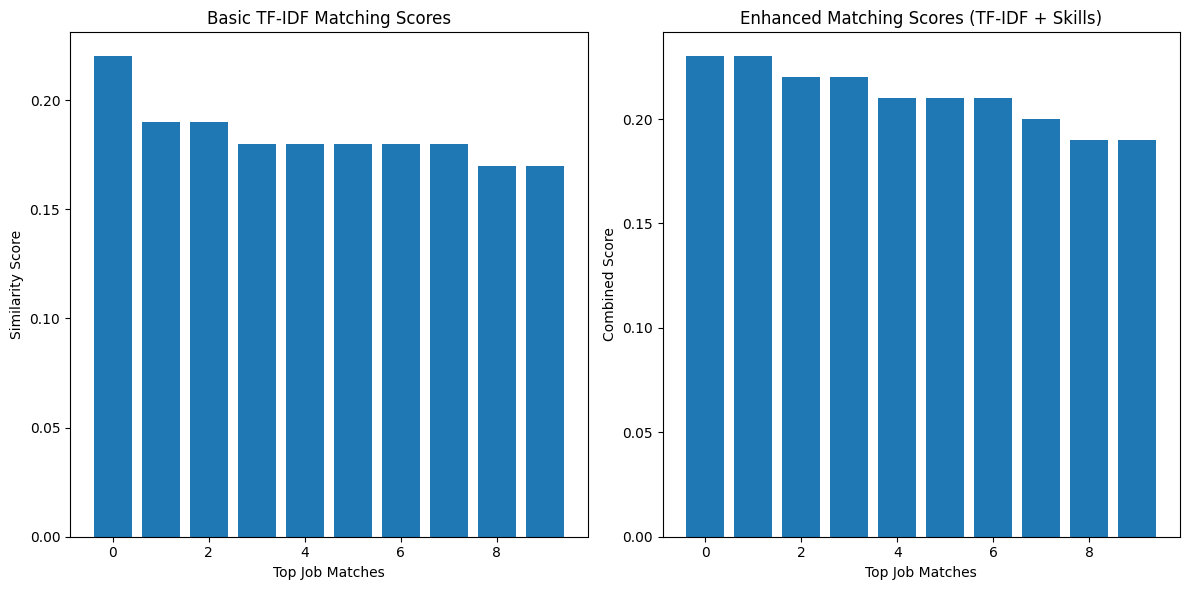

Resume #5 Skills: ['python', 'html', 'excel', 'word', 'powerpoint', 'machine learning']

Resume Text:
SKILLS C Basics, IOT, Python, MATLAB, Data Science, Machine Learning, HTML, Microsoft Word, Microsoft Excel, Microsoft Powerpoint. RECOGNITION Academic Secured First place in B.Tech.Education Details 
August 2014 to May 2018 B.Tech.  Ghatkesar, Andhra Pradesh Aurora's Scientific and Technological Institute
June 2012 to May 2014  Secondary Education Warangal, Telangana SR Junior College
Data Science 


Skill Details 
MS OFFICE- Exprience - Less than 1 year months
C- Exprience - Less than ...

Basic TF-IDF Matching Results:


,Match Score,Job Description
0,0.22,We are looking for a Senior Data Scientist to ...
1,0.19,Machine Learning & Data Science Learning Engin...
2,0.19,"Excited by Big Data, Machine Learning and Pred..."
3,0.18,QUALIFICATIONS\nMasters or PhD level in the co...
4,0.18,Job Description :\n\n6-9 years of strong exper...
5,0.18,We are looking for a Machine Learning (ML) Eng...
6,0.18,Analytics\nData Scientist - QuantumBlack\n\nGu...
7,0.18,Job Description:\n\nKEY QUALIFICATIONS\n\nSoli...
8,0.17,Exp: 2 to 6 years\n\nSeeking an AI/machine lea...
9,0.17,Apply\nshare this job\nEmail Job\nSave Job\n\n...



Enhanced Matching Results (TF-IDF + Skills):


,Match Score,TF-IDF Score,Skills Match,Matched Skills,Job Description
0,0.23,0.19,0.33,"machine learning, python","Excited by Big Data, Machine Learning and Pred..."
1,0.23,0.18,0.33,"machine learning, python",Job Description :\n\n6-9 years of strong exper...
2,0.22,0.17,0.33,"machine learning, python",Apply\nshare this job\nEmail Job\nSave Job\n\n...
3,0.22,0.22,0.20,"machine learning, python",We are looking for a Senior Data Scientist to ...
4,0.21,0.08,0.50,"word, excel, python",Job Description:\n\nThe candidate will be part...
5,0.21,0.13,0.38,"excel, powerpoint, python, machine learning, word",Req ID:93123\n\nWe create smart innovations to...
6,0.21,0.15,0.33,"machine learning, python",Company Description:\nHireXP is committed to b...
7,0.20,0.18,0.22,"machine learning, python",QUALIFICATIONS\nMasters or PhD level in the co...
8,0.19,0.18,0.22,"machine learning, python",Analytics\nData Scientist - QuantumBlack\n\nGu...
9,0.19,0.18,0.22,"machine learning, python",Job Description:\n\nKEY QUALIFICATIONS\n\nSoli...


In [37]:
# Let's compare the basic TF-IDF approach vs the enhanced skills-based approach
import matplotlib.pyplot as plt

def compare_matching_approaches(resume_idx=0):
    """Compare different matching approaches for a given resume"""
    # Basic TF-IDF matching
    basic_matches = match_resume_to_jobs(resume_idx, resume_tfidf, job_tfidf, job_descriptions, top_n=10)
    basic_scores = [float(score) for score in basic_matches['Match Score']]

    # Enhanced matching with skills
    enhanced_matches = enhanced_resume_job_matching(resume_idx, resume_tfidf, job_tfidf,
                                                  resume_skills, job_skills, job_descriptions, top_n=10)
    enhanced_scores = [float(score) for score in enhanced_matches['Match Score']]

    # Plot the comparison
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(basic_scores)), basic_scores)
    plt.title('Basic TF-IDF Matching Scores')
    plt.xlabel('Top Job Matches')
    plt.ylabel('Similarity Score')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(enhanced_scores)), enhanced_scores)
    plt.title('Enhanced Matching Scores (TF-IDF + Skills)')
    plt.xlabel('Top Job Matches')
    plt.ylabel('Combined Score')

    plt.tight_layout()
    plt.show()

    # Print the resume and its extracted skills
    print(f"Resume #{resume_idx} Skills: {resume_skills[resume_idx]}")
    print("\nResume Text:")
    print("="*80)
    print(resumes[resume_idx][:500] + "..." if len(resumes[resume_idx]) > 500 else resumes[resume_idx])

    # Return both dataframes for comparison
    return basic_matches, enhanced_matches

# Compare approaches for a sample resume
basic_df, enhanced_df = compare_matching_approaches(5)  # Try different indices
print("\nBasic TF-IDF Matching Results:")
display(basic_df)
print("\nEnhanced Matching Results (TF-IDF + Skills):")
display(enhanced_df)

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Load your labeled dataset with manually annotated skills
# (Assume it's in a dataframe called 'labeled_data' with columns 'text' and 'skills')

# Extract skills using your model
predicted_skills = [extract_skills(text) for text in labeled_data['text']]

# Convert to binary format for evaluation
def skills_to_binary(skill_list, all_skills):
    return [1 if skill in skill_list else 0 for skill in all_skills]

all_skills = list(set(sum(labeled_data['skills'].tolist(), [])))  # Get unique skills

y_true = [skills_to_binary(skills, all_skills) for skills in labeled_data['skills']]
y_pred = [skills_to_binary(skills, all_skills) for skills in predicted_skills]

# Calculate metrics
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

NameError: name 'labeled_data' is not defined